**2. Implement the Hodgkin-Huxley model of action potential propagation in the
squid giant axon. Solve the partial differential equation using the Crank-Nicholson
method (see e.g. Chapters 5.5, 5.6 and 6.6B from Dayan and Abbott, 2001). Take
$a = 238 \mu m$ and $r_L = 35.4 \Omega cm$. Note that you will need to include your
code with the project report!**

**6. Simulate action potential propagation in a myelinated axon (see e.g. Chapter 6.4
from Dayan and Abbott, 2001). Consider that the nodes of Ranvier (the unmyelinated
spaces) are $2 \mu m$ long and are located at 1 mm intervals along the axon.
Also consider that myelin increases the resistance across the cell membrane by
a factor of 5,000 and decreases the capacitance by a factor of 50.**

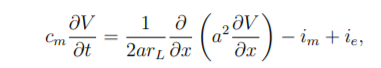

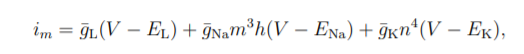

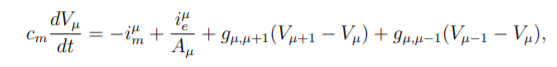

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Classes

#### Model class

In [2]:
class Model:
    """This class is used to store information about the model
    
    Function Parameters stores voltages and conductances: Ek, gk, Ena, gna, Eleak, gleak
    Function Cable stores cable parameters: a, rL, L, Cm
    Function Initial_values stores initial values: n, m, h, V
    Functions for calculating alpha and beta are named by the following rule:
    alpha_n -> an, beta_n -> bn
    """
    def Parameters(self, Ek, gk, Ena, gna, Eleak, gleak):
        """This function is used to store voltages and conductances
        
        Parameters: Ek, gk, Ena, gna, Eleak, gleak
        stores voltages in V, condctances in S/m2
        """
        self.Ek = Ek
        self.gk = gk
        self.Ena = Ena
        self.gna = gna
        self.Eleak = Eleak
        self.gleak = gleak
        
    def Cable(self, a, rL, L, Cm):
        """This function is used to store cable parameters
        
        a = axon radius, in meters
        rL = intracellular resistivity, in Om m
        L = compartment length, in meters
        Cm = membrane capacitance, in F
        """
        self.a = a
        self.rL = rL
        self.L = L
        self.Cm = Cm
        self.A = 2 * np.pi * a * L
        self.g = a / (2 * rL * L * L)
        
    def Myelin(self, ranvier, interval, length, toggle):
        """This function defines how many compartments the model has and which ones are myelinated
        
        ranvier = length of Ranvier node
        interval = interval between beggining of nodes
        length = length of axon
        all parameters are in meters
        
        function returns variable Mask, an M length array
        """
        self.M = int(length / self.L)
        R = int(ranvier / self.L)
        I = int(interval / self.L)
        self.Mask = np.zeros(self.M)
        if toggle == True:
            for i in range(self.M):
                if i % I >= R: self.Mask[i] = 1;
        
        
    def Initial_values(self, n0, m0, h0, V0):
        """This function is used to store the initial values
        
        Values: n0, m0, h0, V0
        """
        self.n = n0
        self.m = m0
        self.h = h0
        self.V = V0
        
        
    # Alpha and Beta
    def an(V):
        return np.divide(10000*(V + 0.055), 1 - np.exp(-100*(V + 0.055)));

    def bn(V):
        return 125 * np.exp(-12.5*(V + 0.065));

    def am(V):
        return np.divide(100000*(V + 0.040), 1 - np.exp(-100*(V + 0.040)));

    def bm(V):
        return 4000 * np.exp(-55.6*(V + 0.065));

    def ah(V):
        return 70 * np.exp(-50*(V + 0.065));

    def bh(V):
        return np.divide(1000, 1 + np.exp(-100*(V +0.035)));

#### Results

In [3]:
class Results:
    """This class is used to store the results after running the HH function
    
    Inputs: n, m, h, V, Ik, Ina
    """
    def __init__(self, n, m, h, V):
        self.n = n
        self.m = m
        self.h = h
        self.V = V

### Functions

#### Crank-Nicholson

In [4]:
def C_N(dt, M, Cm, g, A, gm, I, Ie, V):
    """This function calculates dV using the Crank-Nicholson method
    
    dt = timestep, in seconds
    M = number of compartments
    Cm = membrane capacitance, in F
    g = resistive coupling, in S
    A = compartment surface area
    gm = sum of gi
    I = sum of gi * Ei
    Ie = current input
    V = potential
    
    Function uses the method described in Chapter 6.6B from Dayan and Abbott, 2005
    returns one variable, V_new
    """
    z = 0.5 # Crank-Nicholson
    
    ### Helper variables ###
    b = np.zeros(M)
    c = np.zeros(M)
    d = np.zeros(M)
    f = np.zeros(M)
    
    b[1:M] = g * z * dt / Cm[1:M]
    d[0:M-1] = g * z * dt / Cm[0:M-1]
    c = -gm*z*dt/Cm - b - d
    f = (I + Ie/A)/Cm * z * dt + c * V
    for i in range(M-1):
        f[i+1] += b[i+1] * V[i]
        f[i] += d[i] * V[i+1]
    f = f*2 # getting rid of z
    
    ### Forward prop ###
    c1 = np.zeros(M)
    f1 = np.zeros(M)
    
    c1[0] = c[0]
    f1[0] = f[0]
    
    for i in range(M-1):
        c1[i+1] = c[i+1] + b[i+1] * d[i] / (1-c1[i])
        f1[i+1] = f[i+1] + b[i+1] * f1[i] / (1-c1[i])
        
    ### Backprop ###
    dV = np.zeros(M)
    
    dV[M-1] = f1[M-1] / (1-c1[M-1])
    
    for i in range(M-2, -1, -1):
        dV[i] = (d[i] * dV[i+1] + f1[i]) / (1-c1[i])
    return V + dV

#### Hodgkin-Huxley function

The idea behind HH is that we simulate all of the compartments in parallel.  
All variables will be M x N+1, where M is the number of compartments, N is the number of timesteps.  
A Myelin mask is used to show which compartments are myelinated, changing their resistance and capacitance accordingly.  


In [5]:
def HH(tmax, dt, model, Ie):
    """Calculates the dynamics of the Hodgkin-Huxley model
    
    Input:
    tmax = maximum time, in s
    dt = time step, in s
    model = model parameters(g and E), cable parameters(a, rL, L, Cm) and initial values(n, m, h, V), class Model
    model also contains the functions needed to calculate alpha and beta
    Ie = current input, in A
    
    Output:
    
    """
    # Array dimensions
    N = int(tmax / dt)
    M = model.M
    
    ### Creating the arrays ###
    n = np.zeros((M, N+1))
    m = np.zeros((M, N+1))
    h = np.zeros((M, N+1))
    V = np.zeros((M, N+1))
    gk = np.zeros(M)
    gna = np.zeros(M)
    gl = np.zeros(M)
    Cm = np.zeros(M) 
    gm = np.zeros(M)
    I = np.zeros(M)
    
    ### Initial values ###
    n[:, 0] = model.n
    m[:, 0] = model.m
    h[:, 0] = model.h
    V[:, 0] = model.V
    Cm[:] = model.Cm
    for j in range(M):
        if  model.Mask[j] == 1: Cm[j] /= 50;
            
    for i in range(N):

        ### Membrane conductance ###
        # Potassium
        n[:, i+1] = n[:, i] + (model.an(V[:, i]))*(1 - n[:, i])*dt - (model.bn(V[:, i]))*n[:, i]*dt;
        gk[:] = model.gk * np.power(n[:, i], 4)

        # Sodium
        m[:, i+1] = m[:, i] + (model.am(V[:, i]))*(1 - m[:, i])*dt - (model.bm(V[:, i]))*m[:, i]*dt;
        h[:, i+1] = h[:, i] + (model.ah(V[:, i]))*(1 - h[:, i])*dt - (model.bh(V[:, i]))*h[:, i]*dt;
        gna[:] = model.gna * np.power(m[:, i], 3) * h[:, i] 

        # Leak
        gl[:] = model.gleak
        
            
        ### Voltage ###
        gm = gk + gna + gl
        I = gk * model.Ek + gna * model.Ena + gl * model.Eleak
        for j in range(M):  
            if model.Mask[j] == 1: gm[j] /= 5000; I[j] /= 5000; # Myelin increases resistance by 5000
        
        V[:, i+1] = C_N(dt=dt, M=M, Cm=Cm, g=model.g, A=model.A, gm=gm, I=I, Ie=Ie[:, i], V=V[:, i])
            
    # Storing results
    results = Results(n=n, m=m, h=h, V=V)
    
    return results

### Plot Functions

In [6]:
def Compartment_plot(t, tmax, V, k, title):
    """This function plots the voltage timeseries for k compartments
    
    Input:
    t = timeseries, array length N
    tmax = maximum time the function will plot
    V = voltage values, MxN array
    k = number of compartments to plot
    title = the title you want your graph to have
    """
    x=int(tmax/t[1])
    M = V.shape[0]
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1)
    
    for i in range(k):
        ax.plot(t[0:x], V[M//k*i,0:x], label=str(M//k*i))
    ax.set_title(title, fontsize=22, y=1)
    ax.set_ylabel('Voltage, V', fontsize=16)
    ax.set_xlabel('Time, s', fontsize=16);
    ax.legend()
    bx = plt.gca()
    bx.ticklabel_format(useOffset=False)

In [7]:
def Cable_plot(V, title):
    """This function plots a heatmap of the voltage in the cable
    
    Input:
    V = voltage values, MxN array
    title = the title you want your graph to have
    """
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1)
    a = ax.imshow(V, aspect=1)
    ax.set_title(title, fontsize=22, y=1)
    ax.set_ylabel('Compartment number', fontsize=16)
    ax.set_xlabel('Time, s', fontsize=16);
    fig.colorbar(a, ax=ax)

### Main

#### Time series

In [8]:
# Time variables
tmax = 0.01 # s
dt = 0.00001 # s
N = int(tmax / dt)+1
t = np.linspace(0, tmax, N+1)

#### Simple cable

In [9]:
### Setting model parameters ###
model_simple = Model
model_simple.Parameters(self=model_simple, Ek=-0.077, gk=360, Ena=0.050, gna=1200, Eleak=-0.054387, gleak=3)
model_simple.Initial_values(self=model_simple, n0=0.3177, m0=0.0529, h0=0.5961, V0=-0.065)
model_simple.Cable(self=model_simple, a=2e-06, rL=0.354, L=2e-06, Cm=0.01)
model_simple.Myelin(self=model_simple, ranvier=2e-06, interval=1e-03, length=5e-03, toggle=False)

### Defining injected current ###
Ie = np.zeros((model_simple.M, N))
Ie[0,0:100] = 1e-09

### Running calculations ###
results_s = HH(tmax=tmax, dt=dt, model=model_simple, Ie=Ie)

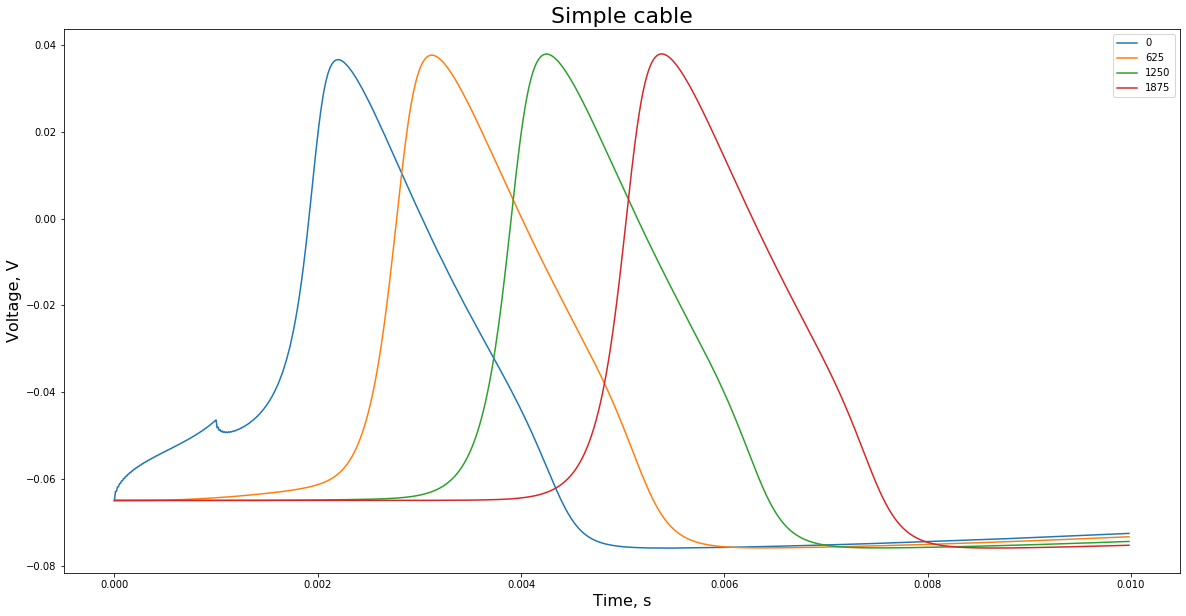

In [10]:
Compartment_plot(t=t, tmax=tmax, V=results_s.V, k=4, title='Simple cable')

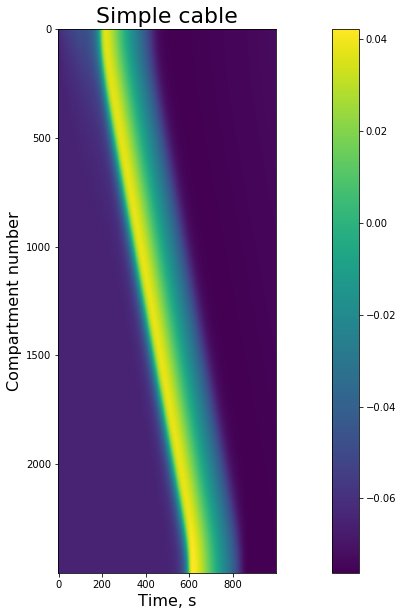

In [11]:
Cable_plot(V=results_s.V, title="Simple cable")

#### Velocity

In [12]:
### Setting model parameters ###
model_velocity = Model
model_velocity.Parameters(self=model_velocity, Ek=-0.077, gk=360, Ena=0.050, gna=1200, Eleak=-0.054387, gleak=3)
model_velocity.Initial_values(self=model_velocity, n0=0.3177, m0=0.0529, h0=0.5961, V0=-0.065)
model_velocity.Cable(self=model_velocity, a=2e-06, rL=0.354, L=2e-06, Cm=0.01)
model_velocity.Myelin(self=model_velocity, ranvier=2e-06, interval=1e-03, length=1e-03, toggle=False)

### Defining injected current ###
Ie = np.zeros((model_velocity.M, N))
Ie[0,0:100] = 1e-09


radius = np.linspace(2e-06, 2e-05, 11)
v = np.zeros(11)

for i, r in enumerate(radius):
    # Setting the radius
    model_velocity.Cable(self=model_velocity, a=r, rL=0.354, L=2e-06, Cm=0.01)
    
    #Running calculations #
    results_v = HH(tmax=tmax, dt=dt, model=model_velocity, Ie=Ie)
    
    # Calculating veocity: the time difference between the peaks in the first and last compartment
    v[i] = model_velocity.M * model_velocity.L / (np.argmax(results_v.V[model_velocity.M-1,:]) - np.argmax(results_v.V[0,:])) / dt

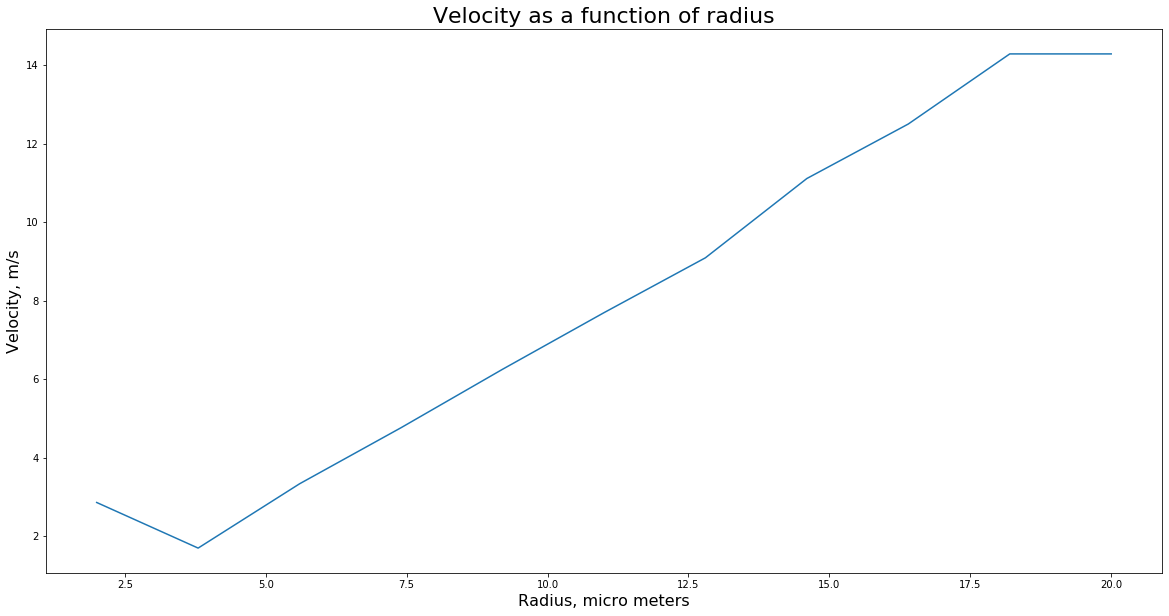

In [18]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(radius/1e-06, v, )
ax.set_title("Velocity as a function of radius", fontsize=22, y=1)
ax.set_ylabel('Velocity, m/s', fontsize=16)
ax.set_xlabel('Radius, micro meters', fontsize=16);
#ax.legend()
bx = plt.gca()
bx.ticklabel_format(useOffset=False)
plt.savefig('velocity_numerical.png')

model_singe.Mask

#### Annihilation

In [19]:
### Setting model parameters ###
model_anni = Model
model_anni.Parameters(self=model_anni, Ek=-0.077, gk=360, Ena=0.050, gna=1200, Eleak=-0.054387, gleak=3)
model_anni.Initial_values(self=model_anni, n0=0.3177, m0=0.0529, h0=0.5961, V0=-0.065)
model_anni.Cable(self=model_anni, a=2e-06, rL=0.354, L=2e-06, Cm=0.01)
model_anni.Myelin(self=model_anni, ranvier=2e-06, interval=1e-03, length=5e-03, toggle=False)

### Defining injected current ###
Ie = np.zeros((model_anni.M, N))
Ie[0,0:100] = 1e-09
Ie[model_anni.M-1,0:100] = 1e-09

### Running calculations ###
results_a = HH(tmax=tmax, dt=dt, model=model_anni, Ie=Ie)

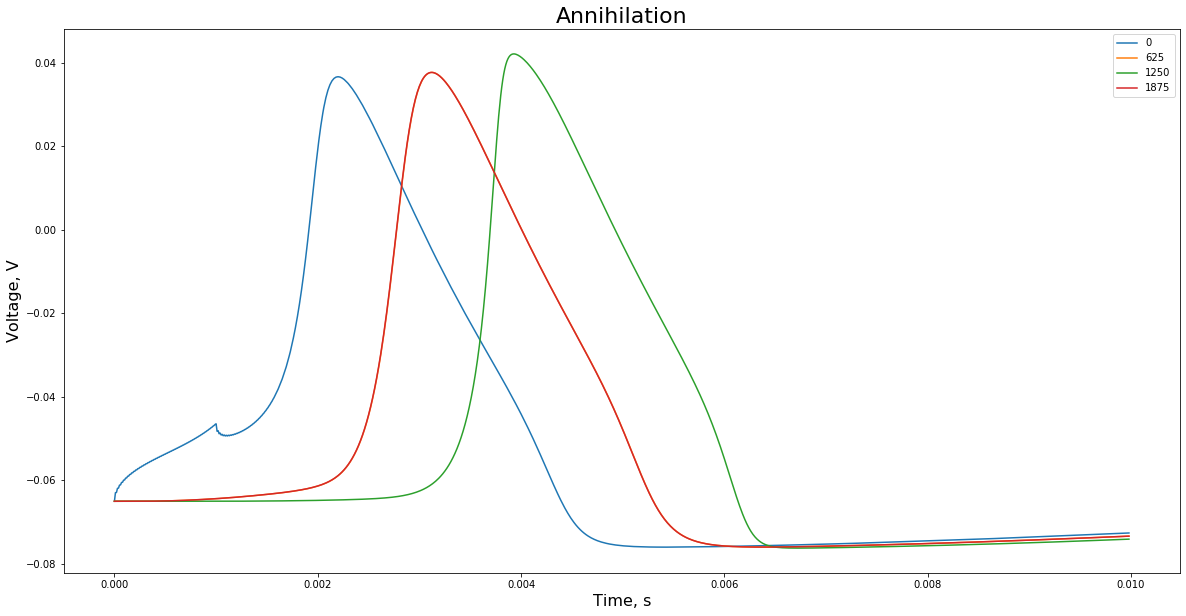

In [20]:
Compartment_plot(t=t, tmax=tmax, V=results_a.V, k=4, title='Annihilation')

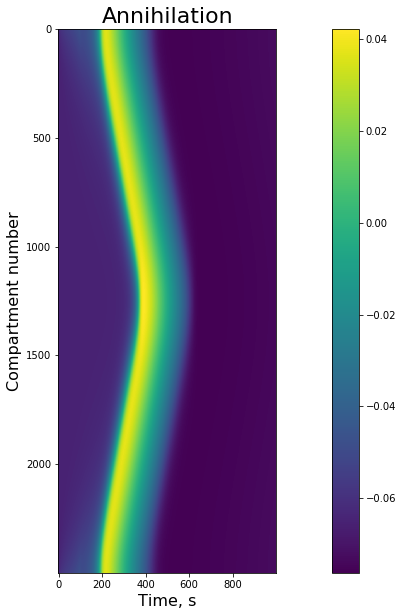

In [21]:
Cable_plot(V=results_a.V, title="Annihilation")

#### Myelin

In [22]:
### Setting model parameters ###
model_myelin = Model
model_myelin.Parameters(self=model_myelin, Ek=-0.077, gk=360, Ena=0.050, gna=1200, Eleak=-0.054387, gleak=3)
model_myelin.Initial_values(self=model_myelin, n0=0.3177, m0=0.0529, h0=0.5961, V0=-0.065)
model_myelin.Cable(self=model_myelin, a=2e-06, rL=0.354, L=2e-06, Cm=0.01)
model_myelin.Myelin(self=model_myelin, ranvier=2e-06, interval=1e-03, length=5e-03, toggle=True) # toggle is True!

### Defining injected current ###
Ie = np.zeros((model_myelin.M, N))
Ie[0,0:100] = 1e-09

### Running calculations ###
results_m = HH(tmax=tmax, dt=dt, model=model_myelin, Ie=Ie)

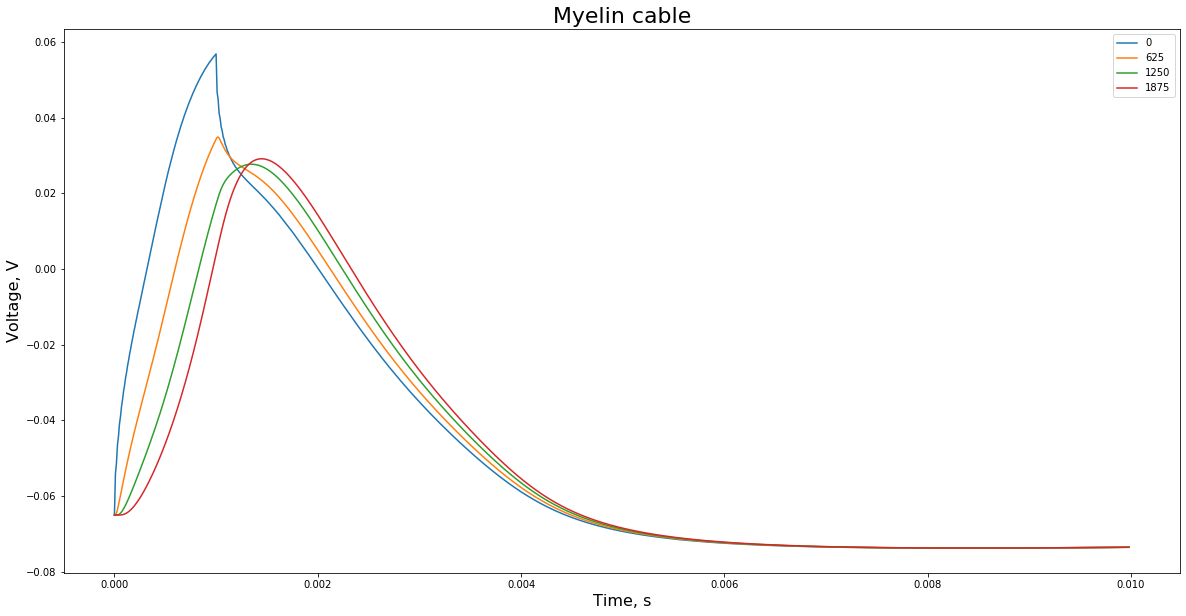

In [23]:
Compartment_plot(t=t, tmax=tmax, V=results_m.V, k=4, title='Myelin cable')

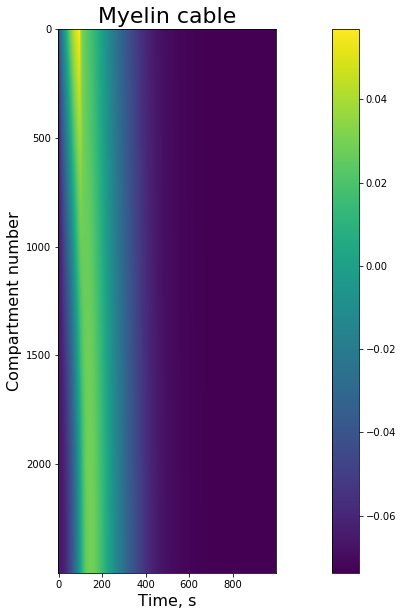

In [24]:
Cable_plot(V=results_m.V, title="Myelin cable")

In [25]:
### Setting model parameters ###
model_myelin = Model
model_myelin.Parameters(self=model_myelin, Ek=-0.077, gk=360, Ena=0.050, gna=1200, Eleak=-0.054387, gleak=3)
model_myelin.Initial_values(self=model_myelin, n0=0.3177, m0=0.0529, h0=0.5961, V0=-0.065)
model_myelin.Cable(self=model_myelin, a=2e-06, rL=0.354, L=2e-06, Cm=0.01)
model_myelin.Myelin(self=model_myelin, ranvier=2e-06, interval=1e-03, length=5e-03, toggle=True) # toggle is True!

### Defining injected current ###
Ie = np.zeros((model_velocity.M, N))
Ie[0,0:100] = 1e-09


radius = np.linspace(2e-06, 2e-05, 11)
v = np.zeros(11)

for i, r in enumerate(radius):
    # Setting the radius
    model_velocity.Cable(self=model_velocity, a=r, rL=0.354, L=2e-06, Cm=0.01)
    
    #Running calculations #
    results_v = HH(tmax=tmax, dt=dt, model=model_velocity, Ie=Ie)
    
    # Calculating veocity: the time difference between the peaks in the first and last compartment
    v[i] = model_velocity.M * model_velocity.L / (np.argmax(results_v.V[model_velocity.M-1,:]) - np.argmax(results_v.V[0,:])) / dt

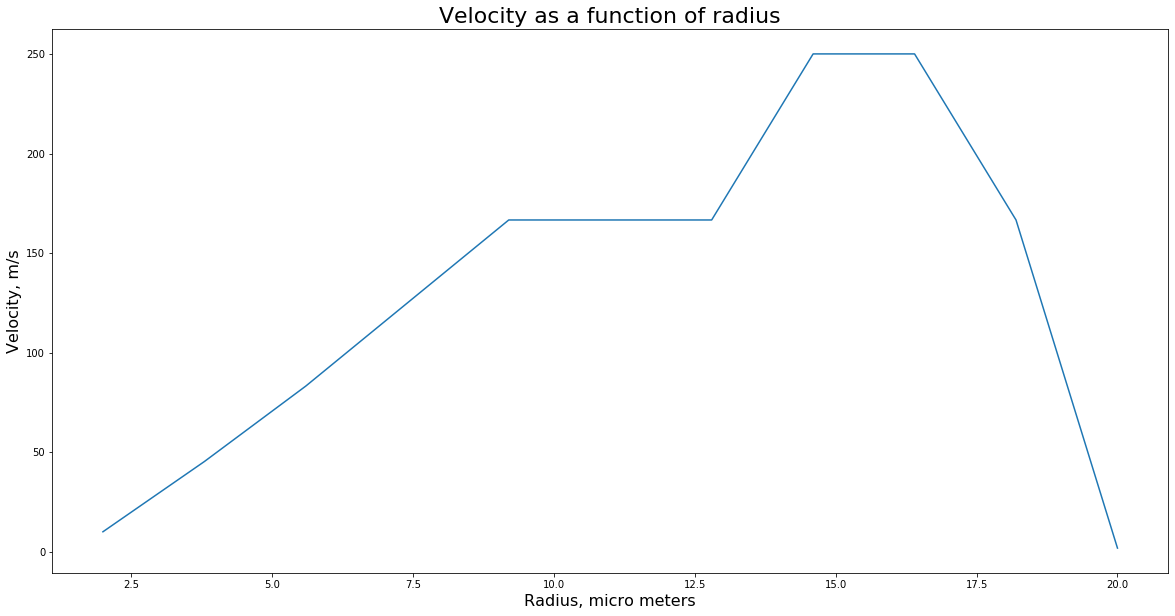

In [26]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(radius/1e-06, v, )
ax.set_title("Velocity as a function of radius", fontsize=22, y=1)
ax.set_ylabel('Velocity, m/s', fontsize=16)
ax.set_xlabel('Radius, micro meters', fontsize=16);
#ax.legend()
bx = plt.gca()
bx.ticklabel_format(useOffset=False)
plt.savefig('velocity_numerical.png')